### Import Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import ReLU, Softmax
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.metrics import AUC
import pandas as pd
# For plotting confusion matrices or advanced metrics
import seaborn as sns
from tensorflow.keras import mixed_precision
# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print("Compute dtype:", policy.compute_dtype)
print("Variable dtype:", policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


### (b) Data Exploration and Pre-Processing

In [11]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Directory paths
train_dir = "/kaggle/input/final-project-zipped-data/data/seg_train"   
test_dir  = "/kaggle/input/final-project-zipped-data/data/seg_test"   

# Basic parameters
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32  # Could also try 16 or 64

# Explore directory structure
classes = sorted(os.listdir(train_dir))
print("Classes (subfolders) found in train_dir:", classes)
for c in classes:
    c_path = os.path.join(train_dir, c)
    num_imgs = len(os.listdir(c_path))
    print(f"Class: {c}, Number of images: {num_imgs}")

test_classes = sorted(os.listdir(test_dir))
print("\nClasses (subfolders) found in test_dir:", test_classes)
for c in test_classes:
    c_path = os.path.join(test_dir, c)
    num_imgs = len(os.listdir(c_path))
    print(f"Class: {c}, Number of images: {num_imgs}")

# Create training & validation datasets directly from directory

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',     # multi-class
    class_names=classes,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)


class_names = train_dataset.class_names
print("Class Names:", class_names)


val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes, 
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False   # Usually don't shuffle test dataset
)

# Add data augmentation (optional, but recommended)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation_layer")

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.prefetch(buffer_size=AUTOTUNE)

Classes (subfolders) found in train_dir: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class: buildings, Number of images: 2191
Class: forest, Number of images: 2271
Class: glacier, Number of images: 2404
Class: mountain, Number of images: 2512
Class: sea, Number of images: 2274
Class: street, Number of images: 2382

Classes (subfolders) found in test_dir: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class: buildings, Number of images: 437
Class: forest, Number of images: 474
Class: glacier, Number of images: 553
Class: mountain, Number of images: 525
Class: sea, Number of images: 510
Class: street, Number of images: 501
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


**EfficientNetB0 Model **

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.1822 - auc: 0.5172 - loss: 2.3454 - val_accuracy: 0.1693 - val_auc: 0.5080 - val_loss: 1.9810
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.2059 - auc: 0.5454 - loss: 2.0392 - val_accuracy: 0.1693 - val_auc: 0.5540 - val_loss: 1.9592
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2159 - auc: 0.5640 - loss: 1.9821 - val_accuracy: 0.1693 - val_auc: 0.5663 - val_loss: 1.9797
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2155 - auc: 0.5779 - loss: 1.9613 - val_accuracy: 0.1693 - val_auc: 0.5581 - val_loss: 2.0283
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2261 - auc: 0.5888 - loss: 1.9339 - val_accuracy: 0.1693 - val_auc: 0.5672 - val_loss: 1.9995
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2350 - auc: 0.6126 - loss: 1.8893 - val_accuracy: 0.1693 - val_auc: 0.5612 - val_loss: 2.0491
Epoch 7/100
351/351 ━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

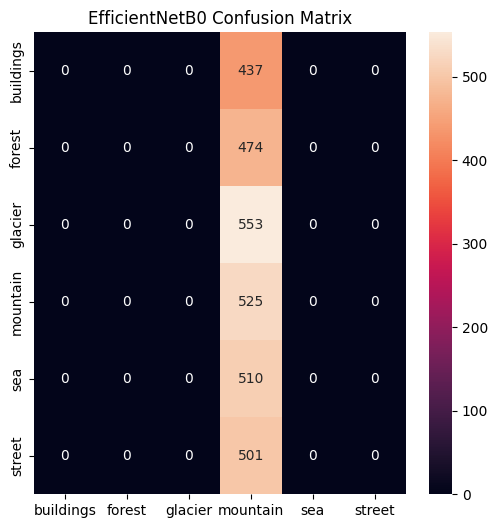

EfficientNetB0 Macro AUC: 0.5231


In [12]:
# GLOBAL Variables to store final metrics
efficientnet_test_acc   = None
efficientnet_macro_prec = None
efficientnet_macro_rec  = None
efficientnet_macro_f1   = None
efficientnet_macro_auc  = None

def Build_efficientnet(num_classes=6):
    input_shape=(224, 224, 3)
    l2_weight=1e-4
    dropout_rate=0.2
    
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = tf.keras.Sequential([
        # Optional data augmentation
        layers.Rescaling(1./255),
        base_model,
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_weight), activation='relu'),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax', name="EfficientNetB0_Classifier")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

# Build model
efficientnet_model = Build_efficientnet(num_classes=len(classes))

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('efficientnet_best.keras', monitor='val_loss', save_best_only=True)

# Train
history_enet = efficientnet_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint]
)

# Load best weights
efficientnet_model.load_weights('efficientnet_best.keras')

# Evaluate
loss, acc, auc_val = efficientnet_model.evaluate(test_dataset, verbose=1)
print(f"EfficientNetB0 Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Test AUC: {auc_val:.4f}")

# Classification Report & Confusion Matrix
y_true = []
y_pred = []
y_prob = []
for images, labels in test_dataset:
    preds = efficientnet_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_prob.extend(preds)

print("Classification Report for EfficientNetB0:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("EfficientNetB0 Confusion Matrix")
plt.show()

# ====== STORE FINAL METRICS ======
global efficientnet_test_acc, efficientnet_macro_prec, efficientnet_macro_rec, efficientnet_macro_f1, efficientnet_macro_auc
efficientnet_test_acc   = acc
efficientnet_macro_prec = report['macro avg']['precision']
efficientnet_macro_rec  = report['macro avg']['recall']
efficientnet_macro_f1   = report['macro avg']['f1-score']

y_prob = np.array(y_prob)
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
efficientnet_macro_auc = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class='ovr')
print(f"EfficientNetB0 Macro AUC: {efficientnet_macro_auc:.4f}")

**VGG16 Model**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


2024-12-16 22:24:28.297947: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-16 22:24:36.986659: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 9.688927262s
Trying algorithm eng0{} for conv (f16[32,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","w

350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7536 - auc: 0.9467 - loss: 0.7453

2024-12-16 22:25:14.593274: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[28,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[28,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-16 22:25:22.284344: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 8.69128051s
Trying algorithm eng0{} for conv (f16[28,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[28,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wa

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7538 - auc: 0.9467 - loss: 0.7447

2024-12-16 22:25:43.091403: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[22,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-16 22:25:48.728198: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.637006373s
Trying algorithm eng0{} for conv (f16[22,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","w

351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 195ms/step - accuracy: 0.7540 - auc: 0.9468 - loss: 0.7442 - val_accuracy: 0.8742 - val_auc: 0.9869 - val_loss: 0.3793
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9220 - auc: 0.9933 - loss: 0.2728 - val_accuracy: 0.8888 - val_auc: 0.9878 - val_loss: 0.3705
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9660 - auc: 0.9980 - loss: 0.1652 - val_accuracy: 0.8838 - val_auc: 0.9859 - val_loss: 0.3944
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9791 - auc: 0.9991 - loss: 0.1261 - val_accuracy: 0.8934 - val_auc: 0.9852 - val_loss: 0.4055
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9873 - auc: 0.9996 - loss: 0.1013 - val_accuracy: 0.8831 - val_auc: 0.9844 - val_loss: 0.4223
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9910 - auc: 0.9997 - loss: 0.0909 - val_accuracy: 0.8881 - val_auc: 0.9825 - val_loss: 0.4288
Epoch 7/100
351/351 ━━━━━━━━━━━━━

2024-12-16 22:28:35.517420: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[24,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[24,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-16 22:28:41.925906: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 7.408626455s
Trying algorithm eng0{} for conv (f16[24,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[24,224,224,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","w

94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 257ms/step - accuracy: 0.8760 - auc: 0.9804 - loss: 0.4620
VGG16 Test Loss: 0.4137, Test Accuracy: 0.8807, Test AUC: 0.9846
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━

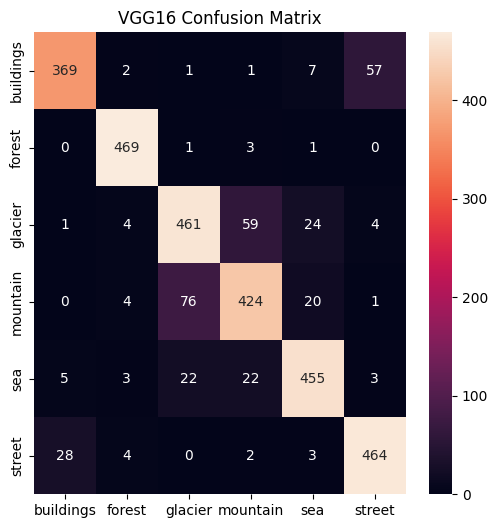

VGG16 Macro AUC: 0.9848


In [13]:
# GLOBAL Variables to store final metrics
vgg16_test_acc   = None
vgg16_macro_prec = None
vgg16_macro_rec  = None
vgg16_macro_f1   = None
vgg16_macro_auc  = None

def Build_vgg16(num_classes=6):
    input_shape=(224, 224, 3)
    l2_weight=1e-4
    dropout_rate=0.2
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = tf.keras.Sequential([
        # Optional data augmentation
        layers.Rescaling(1./255),
        base_model,
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_weight), activation='relu'),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax', name="VGG16_Classifier")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

# Build model
vgg16_model = Build_vgg16(num_classes=len(classes))

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16_best.keras', monitor='val_loss', save_best_only=True)

# Train
history_vgg16 = vgg16_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint]
)

# Load best weights
vgg16_model.load_weights('vgg16_best.keras')

# Evaluate
loss, acc, auc_val = vgg16_model.evaluate(test_dataset, verbose=1)
print(f"VGG16 Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Test AUC: {auc_val:.4f}")

# Classification Report & Confusion Matrix
y_true = []
y_pred = []
y_prob = []
for images, labels in test_dataset:
    preds = vgg16_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_prob.extend(preds)

print("Classification Report for VGG16:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("VGG16 Confusion Matrix")
plt.show()

# ====== STORE FINAL METRICS ======
global vgg16_test_acc, vgg16_macro_prec, vgg16_macro_rec, vgg16_macro_f1, vgg16_macro_auc
vgg16_test_acc   = acc
vgg16_macro_prec = report['macro avg']['precision']
vgg16_macro_rec  = report['macro avg']['recall']
vgg16_macro_f1   = report['macro avg']['f1-score']

y_prob = np.array(y_prob)
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
vgg16_macro_auc = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class='ovr')
print(f"VGG16 Macro AUC: {vgg16_macro_auc:.4f}")

**Resnet 50 Model**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.4369 - auc: 0.7885 - loss: 1.5222 - val_accuracy: 0.4808 - val_auc: 0.8278 - val_loss: 1.3478
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6507 - auc: 0.9131 - loss: 0.9662 - val_accuracy: 0.6739 - val_auc: 0.9305 - val_loss: 0.8633
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6738 - auc: 0.9287 - loss: 0.8717 - val_accuracy: 0.6971 - val_auc: 0.9378 - val_loss: 0.8154
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7002 - auc: 0.9381 - loss: 0.8085 - val_accuracy: 0.7038 - val_auc: 0.9401 - val_loss: 0.7994
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7213 - auc: 0.9454 - loss: 0.7607 - val_accuracy: 0.7224 - val_auc: 0.9439 - val_loss: 0.7720
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7345 - auc: 0.9492 - loss: 0.7318 - val_accuracy: 0.7220 - val_au

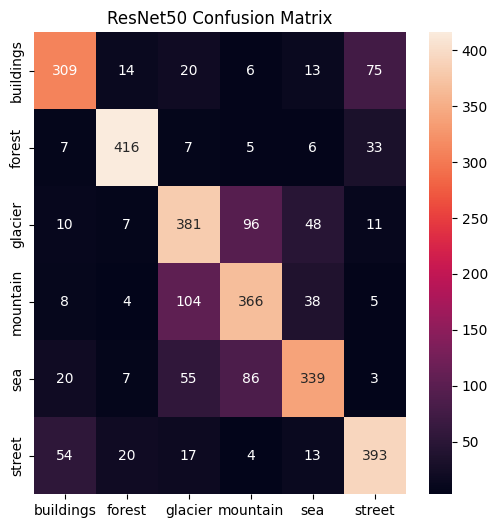

ResNet50 Macro AUC: 0.9464


In [14]:
# GLOBAL Variables to store final metrics
resnet50_test_acc   = None
resnet50_macro_prec = None
resnet50_macro_rec  = None
resnet50_macro_f1   = None
resnet50_macro_auc  = None

def Build_resnet50(num_classes=6):
    input_shape=(224, 224, 3)
    l2_weight=1e-4
    dropout_rate=0.2
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = tf.keras.Sequential([
        # Optional data augmentation pipeline
        layers.Rescaling(1./255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_weight), activation='relu'),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax', name="ResNet50_Classifier")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

# Build the model
resnet50_model = Build_resnet50(num_classes=len(classes))

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_best.keras', monitor='val_loss', save_best_only=True)

# Train
history_r50 = resnet50_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint]
)

# Load best weights
resnet50_model.load_weights('resnet50_best.keras')

# Evaluate
loss, acc, auc_val = resnet50_model.evaluate(test_dataset, verbose=1)
print(f"ResNet50 Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Test AUC: {auc_val:.4f}")

# Classification Report & Confusion Matrix
y_true = []
y_pred = []
y_prob = []
for images, labels in test_dataset:
    preds = resnet50_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_prob.extend(preds)

print("Classification Report for ResNet50:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("ResNet50 Confusion Matrix")
plt.show()

# ====== STORE FINAL METRICS ======
global resnet50_test_acc, resnet50_macro_prec, resnet50_macro_rec, resnet50_macro_f1, resnet50_macro_auc
resnet50_test_acc   = acc
resnet50_macro_prec = report['macro avg']['precision']
resnet50_macro_rec  = report['macro avg']['recall']
resnet50_macro_f1   = report['macro avg']['f1-score']

y_prob = np.array(y_prob)
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
resnet50_macro_auc = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class='ovr')
print(f"ResNet50 Macro AUC: {resnet50_macro_auc:.4f}")

**ResNet100 Model**

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 109ms/step - accuracy: 0.4259 - auc: 0.7822 - loss: 1.5302 - val_accuracy: 0.5257 - val_auc: 0.8539 - val_loss: 1.3052
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5881 - auc: 0.8890 - loss: 1.0885 - val_accuracy: 0.6522 - val_auc: 0.9146 - val_loss: 0.9531
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.6346 - auc: 0.9104 - loss: 0.9740 - val_accuracy: 0.6618 - val_auc: 0.9242 - val_loss: 0.8931
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.6603 - auc: 0.9192 - loss: 0.9222 - val_accuracy: 0.6589 - val_auc: 0.9270 - val_loss: 0.8781
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6801 - auc: 0.9279 - loss: 0.8705 - val_accuracy: 0.6768 - val_auc: 0.9305 - val_loss: 0.8556
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.6671 - auc: 0.9282 - loss: 0.8670 - val_accuracy: 0.6761 - val

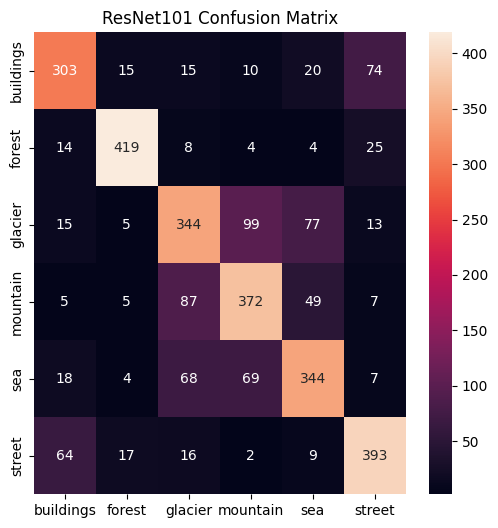

ResNet101 Macro AUC: 0.9348


In [15]:
# GLOBAL Variables to store final metrics
resnet101_test_acc   = None
resnet101_macro_prec = None
resnet101_macro_rec  = None
resnet101_macro_f1   = None
resnet101_macro_auc  = None

def Build_resnet101(num_classes=6):
    input_shape=(224, 224, 3)
    l2_weight=1e-4
    dropout_rate=0.2
    
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    model = tf.keras.Sequential([
        # Optional data augmentation pipeline here
        layers.Rescaling(1./255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_weight), activation='relu'),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax', name="ResNet101_Classifier")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

# Build the model
resnet101_model = Build_resnet101(num_classes=len(classes))

# Callbacks for training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet101_best.keras', monitor='val_loss', save_best_only=True)

# Train the model
history_r101 = resnet101_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint]
)

# Load the best weights
resnet101_model.load_weights('resnet101_best.keras')

# Evaluate on the test set
loss, acc, auc_val = resnet101_model.evaluate(test_dataset, verbose=1)
print(f"ResNet101 Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Test AUC: {auc_val:.4f}")

# Classification Report & Confusion Matrix
y_true = []
y_pred = []
y_prob = []
for images, labels in test_dataset:
    preds = resnet101_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_prob.extend(preds)

print("Classification Report for ResNet101:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("ResNet101 Confusion Matrix")
plt.show()

# ====== STORE FINAL METRICS ======
global resnet101_test_acc, resnet101_macro_prec, resnet101_macro_rec, resnet101_macro_f1, resnet101_macro_auc
resnet101_test_acc   = acc
resnet101_macro_prec = report['macro avg']['precision']
resnet101_macro_rec  = report['macro avg']['recall']
resnet101_macro_f1   = report['macro avg']['f1-score']

# For multi-class AUC, convert y_true to one-hot
y_prob = np.array(y_prob)
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
resnet101_macro_auc = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class='ovr')
print(f"ResNet101 Macro AUC: {resnet101_macro_auc:.4f}")

**Compare Models**

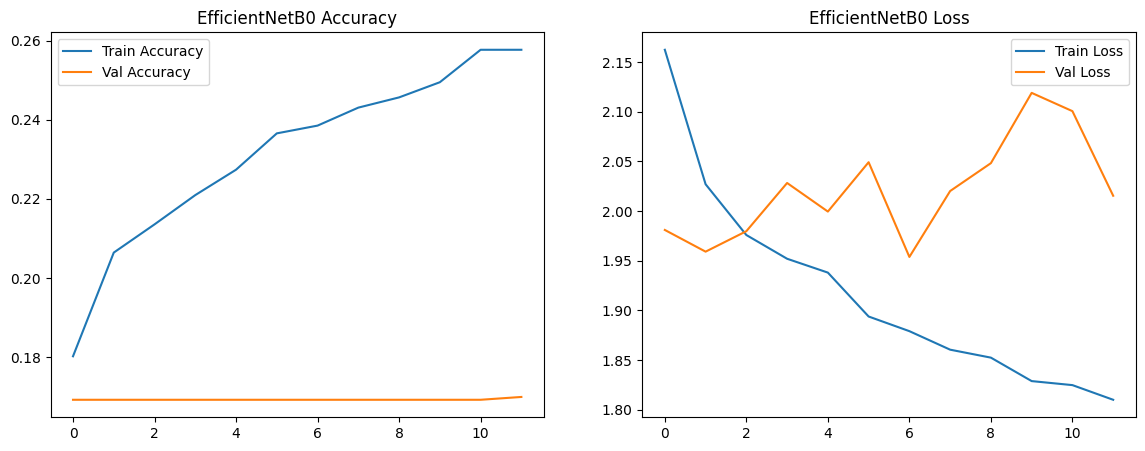

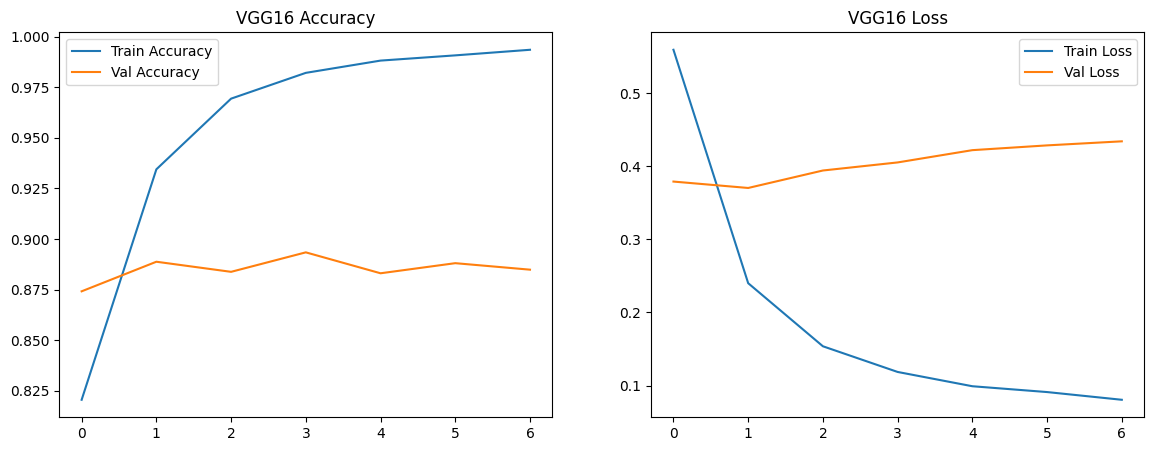

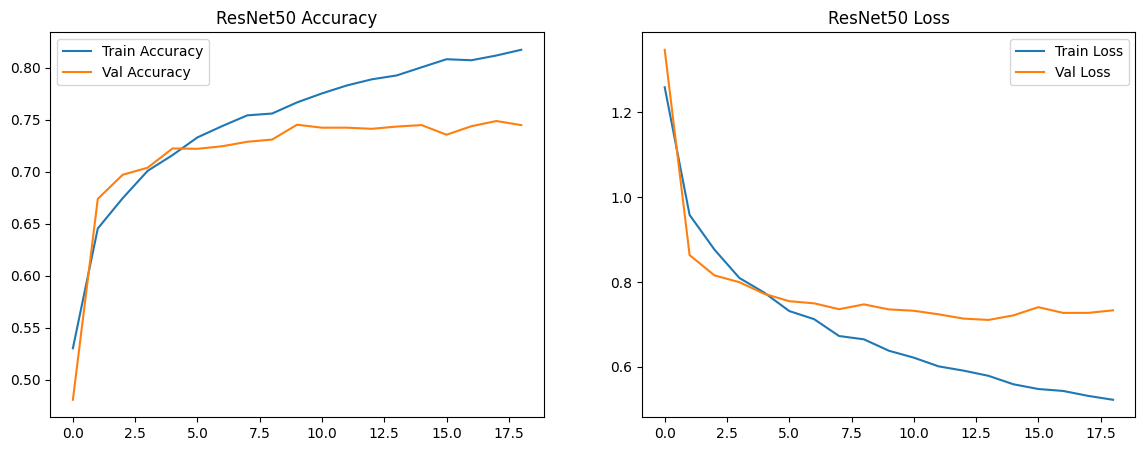

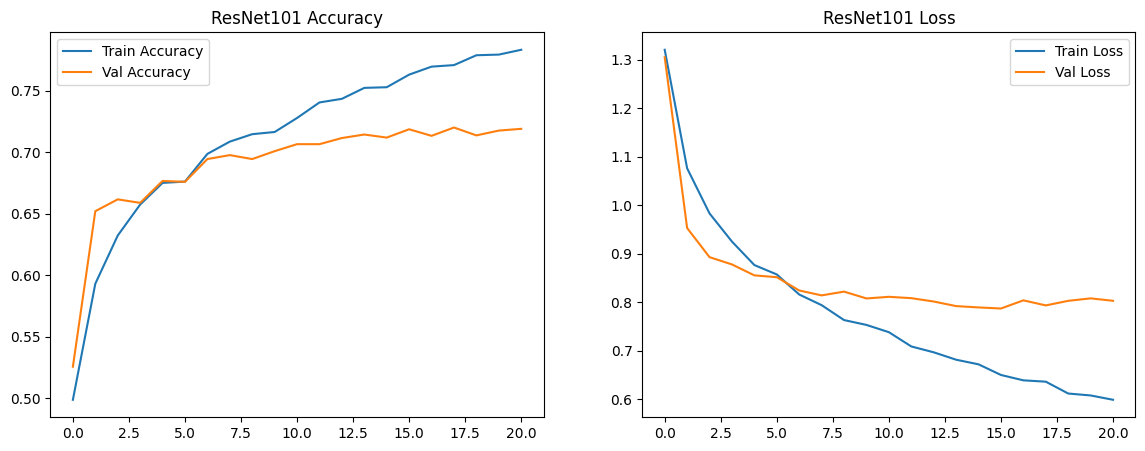

In [18]:
def plot_history(history, model_name=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

# Example usage:
plot_history(history_enet, model_name="EfficientNetB0")
plot_history(history_vgg16, model_name="VGG16")
plot_history(history_r50, model_name="ResNet50")
plot_history(history_r101, model_name="ResNet101")

In [21]:


# Build a dictionary or list of results for easy comparison
model_comparison = {
    'Model':              ['ResNet101', 'ResNet50', 'VGG16', 'EfficientNetB0'],
    'Test_Accuracy':      [resnet101_test_acc, resnet50_test_acc, vgg16_test_acc, efficientnet_test_acc],
    'Macro_Precision':    [resnet101_macro_prec, resnet50_macro_prec, vgg16_macro_prec, efficientnet_macro_prec],
    'Macro_Recall':       [resnet101_macro_rec,  resnet50_macro_rec,  vgg16_macro_rec,  efficientnet_macro_rec],
    'Macro_F1':           [resnet101_macro_f1,   resnet50_macro_f1,   vgg16_macro_f1,   efficientnet_macro_f1],
    'Macro_AUC':          [resnet101_macro_auc,  resnet50_macro_auc,  vgg16_macro_auc,  efficientnet_macro_auc]
}

df_results = pd.DataFrame(model_comparison)
df_results = df_results.round(4)  # round metrics for neat display

# Print the raw table
print("=== Final Model Comparison Table ===")
display(df_results)

# Sort the DataFrame by a chosen metric, e.g. Test_Accuracy
df_sorted = df_results.sort_values(by='Test_Accuracy', ascending=False).reset_index(drop=True)

print("\n=== Sorted by Test Accuracy (Descending) ===")
display(df_sorted)

# The top row after sorting is our best model by that metric
best_model = df_sorted.loc[0, 'Model']
best_acc   = df_sorted.loc[0, 'Test_Accuracy']

print("\n=== Conclusion ===")
print(f"Based on Test Accuracy, the best performing model is {best_model} with Accuracy = {best_acc:.4f}.")

df_sorted_f1 = df_results.sort_values(by='Macro_F1', ascending=False).reset_index(drop=True)
best_model_f1 = df_sorted_f1.loc[0, 'Model']
best_f1        = df_sorted_f1.loc[0, 'Macro_F1']

print(f"\nBased on Macro F1, the best performing model is {best_model_f1} with F1 = {best_f1:.4f}.")

print("\nTherefore, across these models, we can conclude which one clearly outperforms the others "
      "by looking at the highest metrics in our final comparison table.")



=== Final Model Comparison Table ===


,Model,Test_Accuracy,Macro_Precision,Macro_Recall,Macro_F1,Macro_AUC
0,ResNet101,0.7250,0.7290,0.7278,0.7282,0.9348
1,ResNet50,0.7347,0.7410,0.7367,0.7381,0.9464
2,VGG16,0.8807,0.8836,0.8822,0.8825,0.9848
3,EfficientNetB0,0.1670,0.0292,0.1667,0.0496,0.5231



=== Sorted by Test Accuracy (Descending) ===


,Model,Test_Accuracy,Macro_Precision,Macro_Recall,Macro_F1,Macro_AUC
0,VGG16,0.8807,0.8836,0.8822,0.8825,0.9848
1,ResNet50,0.7347,0.7410,0.7367,0.7381,0.9464
2,ResNet101,0.7250,0.7290,0.7278,0.7282,0.9348
3,EfficientNetB0,0.1670,0.0292,0.1667,0.0496,0.5231



=== Conclusion ===
Based on Test Accuracy, the best performing model is VGG16 with Accuracy = 0.8807.

Based on Macro F1, the best performing model is VGG16 with F1 = 0.8825.

Therefore, across these models, we can conclude which one clearly outperforms the others by looking at the highest metrics in our final comparison table.


**Compare Models**